# **H2O NN**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix

import h2o

In [2]:
h2o.init(nthreads=10)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,9 days 2 hours 27 mins
H2O cluster timezone:,Asia/Seoul
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,"1 year, 9 months and 26 days !!!"
H2O cluster name:,h2o
H2O cluster total nodes:,1
H2O cluster free memory:,78.9 Gb
H2O cluster total cores:,64
H2O cluster allowed cores:,64
H2O cluster status:,"locked, healthy"


In [3]:
train=h2o.import_file('../train.csv')
test=h2o.import_file('../test.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
x =train.columns
y = 'FDS_CATH'
x.remove(y)
x.remove('FRST_RCV_DT')

In [5]:
train[y] = train[y].asfactor()

In [6]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch


#activation_opt=["Rectifier", "RecifierWithDropout","Maxout","MaxoutWithDropout"]
#l1_opt = [0, 0.00001, 0.0001, 0.001, 0.01 ,0.1]
#l2_opt = [0, 0.00001, 0.0001, 0.001, 0.01 ,0.1]
#dl_params = {'activation': activation_opt, 'l1': l1_opt, 'l2':l2_opt}

#search_criteria={'strategy': 'RandomDiscrete', 'max_runtime_secs':120, 'seed':1}


#dl_grid = H2OGridSearch(model=H2ODeepLearningEstimator, 
#                        grid_id='dl_grid1',
#                        hyper_params=dl_params,
#                        search_criteria=search_criteria)
#dl_grid.train(x=x, y=y,
#              training_frame=train,
#              hidden=[10, 10], 
#              hyper_params=dl_params,
#             search_criteria=search_criteria)


dl_fit = H2ODeepLearningEstimator(model_id='dl_fit', 
                                   epochs=20, 
                                   hidden=[10,10],
                                   score_interval=1,          #used for early stopping
                                   stopping_rounds=3,         #used for early stopping
                                   stopping_metric='AUC',     #used for early stopping
                                   stopping_tolerance=0.0005, #used for early stopping
                                   seed=1)
dl_fit.train(x=x, y=y, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [7]:
def get_result(model, h2o_data, target, n_group=10):
    pred_result=model.predict(h2o_data)
    performance=model.model_performance(h2o_data)
    pred_result.as_data_frame()

    #h2oframe을 dataframe으로 변환
    pred_result=h2o.as_list(pred_result, use_pandas=True)
    h2o_data=h2o.as_list(h2o_data, use_pandas=True)

    score=pd.concat([h2o_data[target].reset_index().drop('index', axis=1), pred_result['p1']], axis=1)
    score.sort_values('p1', ascending=False, inplace=True)
    score = score.reset_index().drop('index', axis = 1).copy()
    
    n_group=10
    group=['G01','G02','G03','G04','G05','G06','G07','G08','G09','G10']
    bins=round(len(score)/n_group)
    bins_1=len(score)-bins*(n_group-1)

    group_list=[]
    for i in range(n_group):
        if i <n_group-1:
            group_list.append(np.repeat(group[i], bins).tolist())
        else:
            group_list.append(np.repeat(group[i], bins_1).tolist())

    import itertools
    group_list=list(itertools.chain(*group_list))
    score['group']=pd.Series(group_list)

    function_list=['count', 'sum','mean']
    table=score.groupby(['group']).agg(function_list).reset_index()
    
    return score, table

In [8]:
def make_plot(score, table):
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(table['group'], table['FDS_CATH']['mean'], 'bo--')
    
    y_true=score['FDS_CATH']
    y_score=score['p1']
    test_preds=np.where(y_score >0.5, 1, 0)
    
    print(f'precision score:{precision_score(y_true, test_preds)}')
    print(f'recall score: {recall_score(y_true, test_preds)}')
    print(f'auc acore:{roc_auc_score(y_true, y_score)}')
    cm=confusion_matrix(y_true, test_preds)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confision matrix")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

In [10]:
test_score, test_table =get_result(dl_fit, test, target='FDS_CATH')

deeplearning prediction progress: |███████████████████████████████████████| 100%


precision score:0.37333333333333335
recall score: 0.1222707423580786
auc acore:0.785320276317609


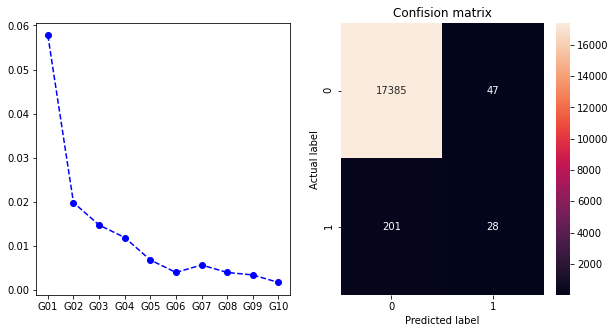

In [11]:
make_plot(test_score, test_table)

In [12]:
test_table

group FDS_CATH                   p1                      
           count  sum      mean count         sum      mean
0   G01     1766  102  0.057758  1766  168.417477  0.095367
1   G02     1766   35  0.019819  1766   75.515598  0.042761
2   G03     1766   26  0.014723  1766   62.686617  0.035496
3   G04     1766   21  0.011891  1766   54.177604  0.030678
4   G05     1766   12  0.006795  1766   46.519091  0.026342
5   G06     1766    7  0.003964  1766   38.555094  0.021832
6   G07     1766   10  0.005663  1766   27.303047  0.015460
7   G08     1766    7  0.003964  1766   16.416800  0.009296
8   G09     1766    6  0.003398  1766    7.438782  0.004212
9   G10     1767    3  0.001698  1767    1.388533  0.000786

In [13]:
train_score, train_table =get_result(dl_fit, train, target='FDS_CATH')

deeplearning prediction progress: |███████████████████████████████████████| 100%


precision score:0.6207455429497569
recall score: 0.10671496238506548
auc acore:0.7572354423956664


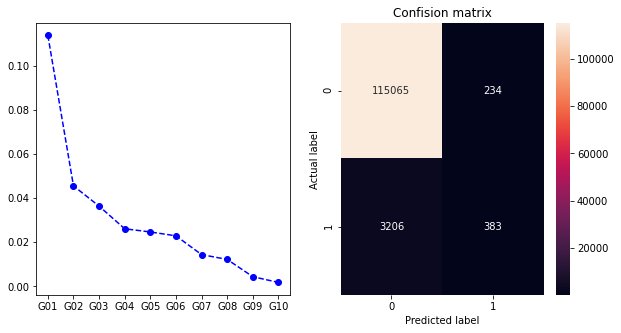

In [14]:
make_plot(train_score, train_table)

In [15]:
train_table

group FDS_CATH                     p1                       
           count   sum      mean  count          sum      mean
0   G01    11889  1352  0.113719  11889  1234.487785  0.103834
1   G02    11889   541  0.045504  11889   507.464639  0.042684
2   G03    11889   432  0.036336  11889   420.275287  0.035350
3   G04    11889   310  0.026075  11889   358.486184  0.030153
4   G05    11889   293  0.024645  11889   306.183435  0.025754
5   G06    11889   272  0.022878  11889   255.799980  0.021516
6   G07    11889   171  0.014383  11889   183.320653  0.015419
7   G08    11889   145  0.012196  11889   110.505984  0.009295
8   G09    11889    52  0.004374  11889    50.279052  0.004229
9   G10    11887    21  0.001767  11887     9.195891  0.000774